In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import tarfile
import io
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlencode
from PIL import Image

In [30]:
#Read CSV

df = pd.read_csv("ZooSpecPhotoDR19_filtered.csv") #Shape (69352, 22)
df = df.sample(100, random_state=42) #To have always the same sample

In [31]:
#Let's work with Hips2Fits

HIPS_URL = "https://alasky.cds.unistra.fr/hips-image-services/hips2fits"

#We need to access the Hips2Fits URL and look for what we want. We will need a function for that.
#Compulsory input parameters: hips, width, height, projection, fov, ra, dec.

def Hips2Fits_access(ra, dec, petroR90_r, width=64, height=64, hips="CDS/P/SDSS9/color"):
    
    #As we could see, one of the compulsory input parameters was the FOV. We need to optimize it with the following equation:
    #FOV = 2*petroR90_r_deg*(1+margin_base)
    
    #We are using margin_base = 0.25 (25%) as default.
    #We also have to be careful. Hips2Fits works with degreen when it comes to FOV. As we are using petroR90_r in
    #the equation and the csv works with arcsecs for it, we need to change units!

    petroR90_r_deg = float(petroR90_r)/3600.0  #from arcsecs to deg
    FOV = 2*petroR90_r_deg*(1+0.25)            

    #Request for an especific galaxy using everything we have mentioned
    params = {
    "hips": hips,
    "ra": ra,
    "dec": dec,
    "width": width, #pixels
    "height": height, #pixels
    "fov": FOV,
    "projection": "TAN", #Minimal distortions for tangential projection
    "format": "jpg" #Format of the images we are getting. It can be jpg, png or fits.
    }

    return (f"{HIPS_URL}?{urlencode(params)}")

In [32]:
#Once we know where to look for, it is time for the storage part

Output_Dir = Path("Images") #Output directory, name of the folder we are shaving everything
Output_Dir.mkdir(exist_ok=True) #Making the directory, and in case it exist, an error won't appear

#The 'problem' here is that we have MORE than 60k images. We will use TAR files to save them. The reason is simple:
#we can save thousands of images in one TAR file, and it will count as just one object instead of thousands.
#Even though it might be tougher to grab just one image, when talking about storing and transferring datasets
#it is way more efficient.

Images_per_TAR = 1000

Images_metadata= [] #Metadata about the downloaded images will be saved here

#We create an empty list at the beginning. Each added element is a triplet (3-tuple) of three elements:
# - Filename: the desired name of the image inside the TAR.
# - Bytes: real binary data of the image downloaded with "requests" (better explained later)
# - Extra: we want to associate the data we have in the CSV to our images.

Images_buffer = []  # [(filename, bytes, extra), ...]
TAR_index = 0 #To count from the beginning

In [33]:
#We know where to find the images, how to store it and the request part. It is time to save the images in our TAR files

def save_images_to_TAR(TAR_path, contents):
    with tarfile.open(TAR_path, "w") as tar: #The "w" is from "write". It creates a new TAR (eliminates if it already exists)
        #The "with" command is called context manager. Its main purpouse is to open a resource (in our case a TAR file),
        #run the block and close the file properly even if there is an error. 
        for filename, bits, extra in contents:
            #Be careful because TAR files don't accept bytes directly but something that behaves as a "file-like object".
            #That is why we use io.BytesIO. It creates temporal files in RAM memory from these bytes.
            File_obj = io.BytesIO(bits)

            #We move the "cursor" to the beginning. When opening or creating a file, Python has an inner "cursor"
            #that indicates where in the file you are. Every time you read or write, the "cursor" moves forward.
            #That is why we need to use the .seek(0) command, so we guarantee that the "cursor" is in the beginning
            #before doing anything.
            File_obj.seek(0)
            
            TAR_info = tarfile.TarInfo(name=f"{filename}.jpg")
            TAR_info.size = len(bits) #Add the size info to TAR_info
            tar.addfile(TAR_info, File_obj)
    print("TAR saved in:", TAR_path)

In [34]:
#When using parallelization we need to control the amount of attempts per image, retry in case of error and quit
#after several failed attempts so we don't get stucked.

#When accessing Hits2Fits, as we have a lot of requests, we won't be doing it one by one. For that, we need to keep a 'session' open
#all the time. It will save up time. How do we do that? With Python’s standard library "requests" for HTTP requests.

session = requests.Session() #Creates a persistent session object that maintains certain things between requests:
                            #  - Persistent TCP connection to avoid repeated handshake for each image.
                            #  - Cookies to be reused automatically if the server uses them for authentication.

def download_with_retries(ra, dec, petroR90_r, max_retries=5, delay=2):
    URL = Hips2Fits_access(ra, dec, petroR90_r) #URL of the desired image to download.
    for attempt in range(1, max_retries + 1):
        try:
            response = session.get(URL, timeout=30) #We get into our session (defined with the request.Session())
            if response.status_code == 200: #This code means the download has succeded 
                return response.content #Return the bytes
            else:
                print(f"[{attempt}/{max_retries}] Error {response.status_code} in {URL}")
        except requests.RequestException as e: #These are type of error that aren't given in the form of ERROR #NUMBER. These
                                               #most of the times are associated with connection errors.
            print(f"[{attempt}/{max_retries}] Connection error: {e}")
        if attempt < max_retries:
            time.sleep(delay)  #Wait before the following attempt
    print(f"Permanent error after {max_retries} retries: {URL}")
    return None

In [35]:
"""#Adding write_shard function to save the TAR files when we reach the limit of images per TAR

def write_shard(TAR_index: str, Images_buffer: list):
    if Images_buffer:
        TAR_path = Output_Dir / f"Images_{TAR_index:06d}.tar" #why 06d? To have leading zeros and all the TAR files have the same length
        save_images_to_TAR(TAR_path, Images_buffer)
"""

'#Adding write_shard function to save the TAR files when we reach the limit of images per TAR\n\ndef write_shard(TAR_index: str, Images_buffer: list):\n    if Images_buffer:\n        TAR_path = Output_Dir / f"Images_{TAR_index:06d}.tar" #why 06d? To have leading zeros and all the TAR files have the same length\n        save_images_to_TAR(TAR_path, Images_buffer)\n'

In [ ]:
#Parallel execution

#As we don't want to be working TAR by TAR, we can parallelize. Parallelization is the process of running multiple tasks
#simultaneously instead of sequentially.

with ThreadPoolExecutor(max_workers=20) as executor: #Up to 20 images downloaded at the same time.
    
    #Let's write a list of parallel tasks (in our case, image downloading). We have to use a dictionary to avoid errors:
    futures = {executor.submit(download_with_retries, t.ra, t.dec, t.petroR90_r): t
    for t in df.itertuples()}
    
    Images_metadata_csv = [] #We create an empty list to save the metadata of the images in the CSV file.
    #itertuples() reiterate in every row of the DataFrame. Each row is converted in a namedtuple,
    #which means that we have access to the columns by name or position.

    completed = 0 #We start the counter
    
    for f in as_completed(futures): #as_completed(futures) is an iterator that returns the 'futures' (our lists) as they finish.
        Images_metadata = futures[f]
        bits = f.result() 
        if bits is not None:
            filename = str(Images_metadata.objid)
            extra = {
                "id": Images_metadata.objid,
                "ra": Images_metadata.ra,
                "dec": Images_metadata.dec,
                "spiral": getattr(Images_metadata, "spiral", None),
                "elliptical": getattr(Images_metadata, "elliptical", None),
            }
            Images_buffer.append((filename,bits,extra))
            Images_metadata_csv.append(extra) #We add the metadata of the image to the list we will use for the CSV file.            
        else:
            continue #We don't want everything to stop
        completed += 1

        if completed % 100 == 0: #completed % 100 calculates the remainder of that division. In other words: if it's 100% completed.
            print("We got this!")

        if len(Images_buffer) >= Images_per_TAR: #If the TAR is full
            save_images_to_TAR(Output_Dir / f"TAR-{TAR_index:06d}.tar", Images_buffer) # creates the TAR file on your disk
            Images_buffer = [] #We empty it so we can start filling again
            TAR_index += 1 # So the following TAR gets the next number

#We write last shard if not empty
if Images_buffer: #Checks if the list is not empty.
    save_images_to_TAR(Output_Dir/ f"TAR-{TAR_index:06d}.tar", Images_buffer)

We got this!
TAR saved in: Images/TAR-000000.tar


In [37]:
#We have finished with the downloads. Now let's save the metadata we got as a compressed CSV

metadata_df = pd.DataFrame(Images_metadata_csv)

#Making the directory, and in case it exist, an error won't appear
Output_Dir.mkdir(parents=True, exist_ok=True) #The command parents=True creates all the missing parent directories in the path.

metadata_df.to_csv(Output_Dir / "metadata.csv.gz", index=False, compression="gzip")

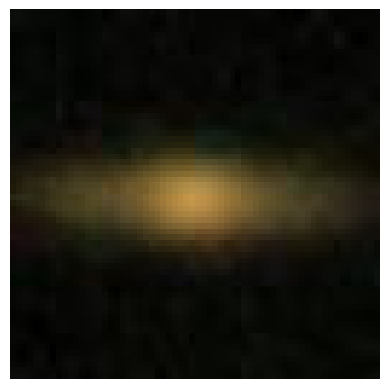

In [38]:
#Let's see if we can plot any image

#We are openning the first TAR (for example)
tar_path = "Images/TAR-000000.tar"
with tarfile.open(tar_path, "r") as tar:
    # list contents
    members = tar.getmembers()
    # extract the first cutout
    img_member = members[0]
    img_bytes = tar.extractfile(img_member).read()

# show the image
img = Image.open(io.BytesIO(img_bytes)) 
plt.imshow(img)
plt.axis("off")
plt.show()

#print metadata of the first image of the tar file  

